# Confidence intervals via Constrained Inference - Benchmark data

This notebook uses applies the code developed for calculating confidence intervals for the causal effect between two variables under the equal variance assumption and applies it to 5 benchmark data pairs. It is assumed that the data follows a Gaussian distribution and the relationship between the two variables is linear.

The standard approach as well as the two-step approach for $\alpha_1 \in \{0.01, 0.02, 0.03\}$ are investigated.

Loading the required libraries:

In [25]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm, multivariate_normal
from scipy.stats import probplot
from scipy.optimize import minimize
from pynverse import inversefunc

## Methods for calculation of confidence intervals
(Identical to other notebook)

In [26]:
def empirical_sigmas(x1, x2):
    s11 = np.mean(x1**2)
    s12 = np.mean(x1*x2)
    s22 = np.mean(x2**2)
    return s11, s12, s22

In [27]:
def llh(x1, x2):
    s11, s12, s22 = empirical_sigmas(x1, x2)
    RV = multivariate_normal([0, 0], [[s11, s12], [s12, s22]])
    L_hat = RV.logpdf(np.stack([x1, x2], axis = 1))
    return np.sum(L_hat)

def nllh_inv(x1, x2):
    """
    a[0], a[1], a[2] <=> k1, k2, k3
    """
    eps = 1e-6
    n = x1.shape[0]
    C = 2*n*np.log(2*np.pi)
    nllh = lambda a: np.inf if a[0]*a[2] - a[1]**2 <= 0\
                            else 0.5 * (C - n*np.log(a[0]*a[2] - a[1]**2)
                                        + np.sum(a[0]*x1**2 + 2*a[1]*x1*x2 + a[2]*x2**2))
    
    grad_nllh = lambda a: np.array([- np.sign(a[2]) * np.inf if a[0]*a[2] - a[1]**2 <= 0\
                                    else 0.5 * (-n*a[2]/(a[0]*a[2]-a[1]**2) + np.sum(x1**2)),
                                    np.sign(a[1]) * np.inf if a[0]*a[2] - a[1]**2 <= 0\
                                    else 1.0 * (n*a[1]/(a[0]*a[2]-a[1]**2) + np.sum(x1*x2)),
                                    -np.sign(a[0]) * np.inf if a[0]*a[2] - a[1]**2 <= 0\
                                    else 0.5 * (-n*a[0]/(a[0]*a[2]-a[1]**2) + np.sum(x2**2))])
    return nllh, grad_nllh

In [28]:
def ineq_constraints(kind):
    assert kind in ['cov', 's11 >= s22', 's11 <= s22']
    eps = 1e-7
    if kind == 's11 >= s22':
        fun = lambda a: np.array([a[0], a[2],
                                  a[0]*a[2] - a[1]**2 - eps,
                                  a[2] - a[0]])
        jac = lambda a: np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0],
                                  [a[2], -2*a[1], a[0]],
                                  [-1.0, 0.0, 1.0]])
    elif kind == 's11 <= s22':
        fun = lambda a: np.array([a[0], a[2],
                                  a[0]*a[2] - a[1]**2 - eps,
                                  a[0] - a[2]])
        jac = lambda a: np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0],
                                  [a[2], -2*a[1], a[0]],
                                  [1.0, 0.0, -1.0]])
    elif kind == 'cov':
        fun = lambda a: np.array([a[0], a[2],
                                  a[0]*a[2] - a[1]**2 - eps])
        jac = lambda a: np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0],
                                  [a[2], -2*a[1], a[0]]])
    ineq_cons = {'type' : 'ineq', 'fun' : fun, 'jac' : jac}
    return ineq_cons

def eq_constraints(c0):
    fun = lambda a: np.array([c0*a[0] + a[1]])
    jac = lambda a: np.array([c0, 1.0, 0.0])
    eq_cons = {'type': 'eq', 'fun': fun, 'jac': jac}
    return eq_cons

In [29]:
def statistic(x1, x2, c0):
    # Determining constraints for optimisation   
    if np.abs(c0) >= 1:
        ineq_cons = ineq_constraints('cov')
        eq_cons = eq_constraints(c0)
        constraints = [eq_cons, ineq_cons]
    elif 0 < np.abs(c0) < 1:
        ineq_cons = ineq_constraints('s11 >= s22')
        eq_cons = eq_constraints(c0)
        constraints = [eq_cons, ineq_cons]
    else:
        ineq_cons = ineq_constraints('s11 <= s22')
        constraints = ineq_cons
        
    # estimates of concentration matrix entries
    s11, s12, s22 = empirical_sigmas(x1, x2)
    a0 = np.array([s22, -s12, s11]) / (s11 * s22 - s12**2)
    # Getting function handles and minimisation with SLSQP
    nllh, grad_nllh = nllh_inv(x1, x2)
    res = minimize(nllh, a0, method = 'SLSQP', jac = grad_nllh,
                   constraints = constraints,
                   options = {'ftol' : 1e-9, 'maxiter': 1000})
    return 2 * (llh(x1, x2) + res.fun)

In [30]:
def get_ci(x1, x2, alpha, low, high, h, two_step, alpha_1):
    """
    :param x1, x2: data
    :param alpha: allowed type-I error
    :param low, high: range for testing c0's
    :param h: step length / distance between neighbouring c0's
    :param two_step: (bool) apply two-step approach
    :param alpha_1: alpha for first step of two-step procedure
    :returns: piecewise confidence interval
    """
    # 1st step
    if two_step:
        assert alpha_1 < alpha
    eps = 1e-6
    # Getting quantiles
    comp_1 = chi2.ppf(1 - alpha, df = 1) 
    if two_step:
        n = x1.shape[0]
        s11, s12, s22 = empirical_sigmas(x1, x2)
        # We use that simulated data is normal
        std = np.sqrt(2 * (s11**2 - 2 * s12 + s22**2))
        q = norm.ppf(1 - alpha_1/2)
        ci = (s11 - s22) + np.array([-q, q]) * std / np.sqrt(n)
        if ci[0] <= 0 <= ci[1]:
            comp_01 = chi2.ppf(1 - 2 * (alpha-alpha_1), df = 1)
            cdf_12 = lambda x: 0.5 * (chi2.cdf(x, df = 1) + chi2.cdf(x, df = 2))
            comp_12 = inversefunc(cdf_12, y_values = [1-(alpha-alpha_1)])[0]
        else:
            comp_01 = eps
            comp_12 = chi2.ppf(1 - (alpha-alpha_1), df = 1)
    else:
        comp_01 = chi2.ppf(1 - 2 * alpha, df = 1)
        cdf_12 = lambda x: 0.5 * (chi2.cdf(x, df = 1) + chi2.cdf(x, df = 2))
        comp_12 = inversefunc(cdf_12, y_values = [1-alpha])[0]
    
    # 2nd step
    S1_low, S1_high, S2 = [], [], []
    c0 = low
    while c0 <= high:
        s = statistic(x1, x2, c0)
        if c0 <= -1 and s <= comp_1:
            S1_low.append(c0)
        elif c0 >= 1 and s <= comp_1:
            S1_high.append(c0)
        elif 0 < np.abs(c0) < 1 and s <= comp_12:
            S2.append(c0)
        c0 = c0 + h
    
    def extract_ci(S):
        return np.array([min(S) - 0.5*h, max(S) + 0.5*h]) if len(S) > 0 else None
    I1_low = extract_ci(S1_low)
    I1_high = extract_ci(S1_high)
    I2 = extract_ci(S2)
    
    if low <= 0 <= high:
        s = statistic(x1, x2, 0)
        S3 = s <= comp_01
    else:
        S3 = False
    # I1_low, I1_high, I2 are nd-arrays; S3 is bool
    return I1_low, I1_high, I2, S3

In [31]:
def estimate_causal_effect(x1, x2):
    s11, s12, s22 = empirical_sigmas(x1, x2)
    if s11 > s22:
        return s12 / s22
    else:
        return 0

## Data

We use the [CauseEffectPairs](https://dl.acm.org/doi/pdf/10.5555/2946645.2946677?download=true) dataset which consists of pairs of variables for which the underlying causal relationship is known.

Since we suppose that the error term for both variables has equal variance and that the relationship between them is of linear nature, we have to limit our investigation to pairs where these assumptions are plausible. Hence, we consider the pairs `0066`, `0067` (stock returns of 2 different companies), `0076` (population growth and food consumption), `0089` and `0090` (root decomposition in different months).

We read in the data, centre it and scale both variables by the *same* factor preserving the variance difference but accounting for different scales between the pairs considered:

In [32]:
names = ['0066', '0067', '0089', '0090', '0076']
aliases = ['stock1', 'stock2', 'root1', 'root2', 'food']
n_data = len(names)
data = dict() 
for name, alias in zip(names, aliases):
    file_name = 'data/pair{}.txt'.format(name)
    df = pd.read_csv(file_name, sep = '\s+', header = None,
                     names = ['x', 'y'], engine = 'python')
    d = df[['x', 'y']].values
    # transformation: centring and scaling
    data[alias] = (d - np.mean(d, axis=0)) / np.std(d[:,0])

Since we also assume the distributions to be Gaussian, we use QQ-plots to verify this assumption:

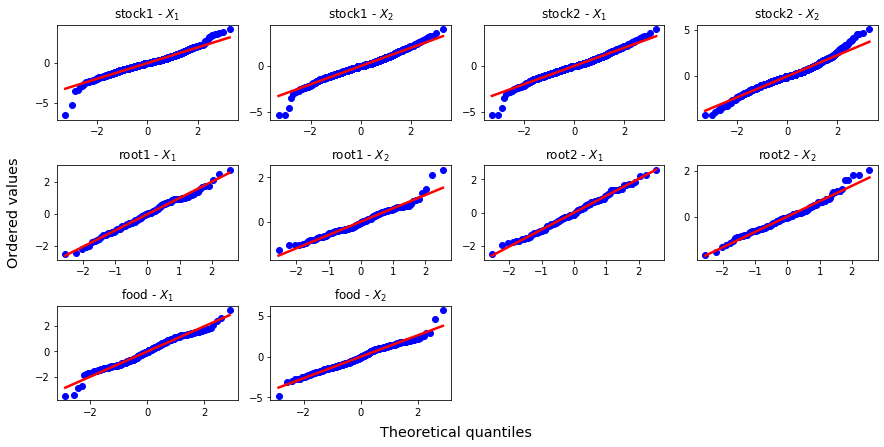

In [53]:
fig, axes = plt.subplots(nrows = 3, ncols = 4, **{'figsize' : (12, 6)})

for i, (alias, d) in enumerate(data.items()):
    r = i//2
    c = (i%2) * 2
    probplot(d[:,0], dist = "norm", plot = axes[r, c])
    axes[r, c].get_lines()[1].set_linewidth(2.5)
    axes[r, c].set_title(alias + " - " + r"$X_1$", {'fontsize' : 'large'})
    axes[r, c].set_xlabel(None)
    axes[r, c].set_ylabel(None)
    probplot(d[:,1], dist = "norm", plot = axes[r, c+1])
    axes[r, c+1].get_lines()[1].set_linewidth(2.5)
    axes[r, c+1].set_title(alias + " - " + r"$X_2$", {'fontsize' : 'large'})
    axes[r, c+1].set_xlabel(None)
    axes[r, c+1].set_ylabel(None)

fig.delaxes(axes[2, 2])
fig.delaxes(axes[2, 3])
fig.text(0.5, -0.02, 'Theoretical quantiles', ha = 'center', size = 'x-large')
fig.text(-0.02, 0.5, 'Ordered values', va = 'center', rotation='vertical', size = 'x-large')
fig.tight_layout()
fig.savefig("qq_plots.eps")

## Confidence intervals
Having verified all assumptions, we implement a method that calculates the confidence interval and an estimate of the causal effect.

In [54]:
def get_cis(direction, alpha, low, high, h):
    assert direction in ['X1 <- X2', 'X1 -> X2']
    ces = dict()
    cis = []
    for alpha_a in [0, 0.01, 0.02, 0.03]:
        ci = dict()
        for alias, d in data.items():
            if direction == 'X1 <- X2':
                x1, x2 = d[:,0], d[:,1]
            else:
                x1, x2 = d[:,1], d[:,0]
            ces[alias] = estimate_causal_effect(x1, x2)
            if alpha_a == 0:
                ci[alias] = get_ci(x1, x2, alpha, low, high, h, False, 0)
            else:
                ci[alias] = get_ci(x1, x2, alpha, low, high, h, True, alpha_a)
        cis.append(ci)
    return cis, ces

Moreover, we develop a method for visualising the results:

In [83]:
def visualise(cis, ces):
    w = 0.1
    x = np.arange(len(aliases)) - 1.5 * w
    labels = [r"standard", r"two-step, $\alpha_1 = 0.01$",
              r"two-step, $\alpha_1 = 0.02$", r"two-step, $\alpha_1 = 0.03$"]
    cmap = plt.get_cmap("tab10")
    fig, ax = plt.subplots(**{'figsize' : (13, 5)})
    ll, bb, _, hh = ax.get_position().bounds
    ax.set_position([ll, bb, 0.6, hh])
    for i, ci in enumerate(cis):
        for pos, (alias, t) in zip(x, ci.items()):
            if i == 0:
                ax.hlines(y = ces[alias], xmin = pos - 0.5*w,
                           xmax = pos + 3.5*w, color = 'black')
            for j, I in enumerate(t):
                if j < 3 and I is not None:
                    ax.bar(pos+i*w, bottom = I[0], height = I[1]-I[0],
                           width = w/3, label = labels[i], color = cmap(i))
                elif I:
                    ax.scatter(pos+i*w, 0, label = labels[i], color = cmap(i))
    ax.tick_params(labelsize = 'large')
    ax.set_xticks(x + 1.5*w)
    ax.set_xticklabels(aliases, fontsize = 'x-large')
    patches = [matplotlib.patches.Patch(color = cmap(i), label = l) for i, l in enumerate(labels)]
    ax.legend(handles = patches, bbox_to_anchor = (1.02, 1),
              loc = 'upper left', borderaxespad = 0., fontsize = 'large')
    fig.savefig("figure.eps")

Calculation and visualisation of the confidence intervals for the causal effect of $X_2$ on $X_1$:

In [55]:
cis1, ces1 = get_cis('X1 <- X2', 0.05, -3, 3, 0.005)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


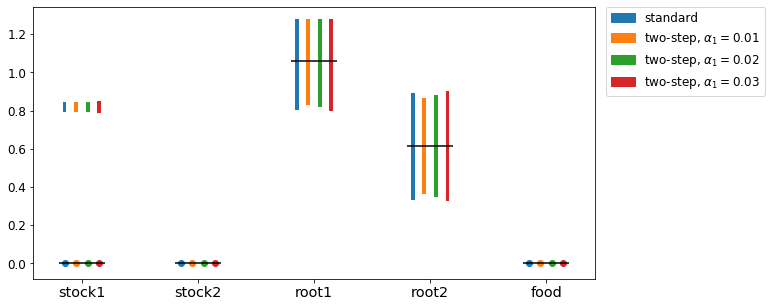

In [84]:
visualise(cis1, ces1)

Calculation and visualisation of the confidence intervals for the causal effect of $X_1$ on $X_2$:

In [58]:
cis2, ces2 = get_cis('X1 -> X2', 0.05, -3, 3, 0.005)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


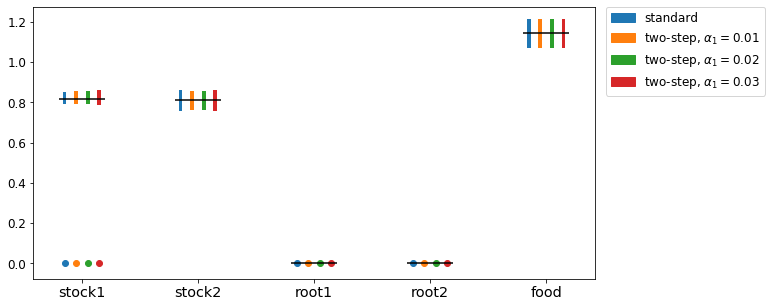

In [85]:
visualise(cis2, ces2)

## Analysis
We know that the true causal relationships are directed as follows:
* `stock1`: $X_1 \rightarrow X_2$
* `stock2`: $X_1 \rightarrow X_2$
* `root1`: $X_1 \leftarrow X_2$
* `root2`: $X_1 \leftarrow X_2$
* `food`: $X_1 \rightarrow X_2$

All of these relationships were retrieved correctly. In terms of the length of the confidence intervals, for most cases the considered approaches are very similar but in some situations the two-step approach with $\alpha_1 = 0.01$ yields a considerably better result.

Interestingly, the confidence intervals on the `root1` dataset are very discontinuous. This can be traced back to the fact that the empirical variance of $X_1$ and $X_2$ are almost equal. Consequently, the direction of the causal relationship is very hard to deduce which is reflected in the confidence intervals.

In [63]:
x1, x2 = data['stock1'][:,0], data['stock1'][:,1]
s11, _, s22 = empirical_sigmas(x1, x2)
print("Variance of X_1: ", s11)
print("Variance of X_2: ", s22)

Variance of X_1:  1.0
Variance of X_2:  1.0105600067254246
